In [39]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np
import os
from copy import deepcopy
from transformers import pipeline

In [3]:
import matplotlib.pyplot as plt

def display_images_with_titles(images, titles, cols=3):
    """Display a list of PIL images with their titles in a grid format.

    Args:
        images (list): List of PIL Image objects.
        titles (list): List of titles corresponding to each image.
        cols (int): Number of columns in the grid.
    """
    # Calculate the number of rows needed
    n_images = len(images)
    rows = (n_images + cols - 1) // cols  # Ceiling division

    # Create a figure with specified size
    plt.figure(figsize=(12, 4 * rows))

    for i, (image, title) in enumerate(zip(images, titles)):
        ax = plt.subplot(rows, cols, i + 1)  # Create subplot
        ax.imshow(image)  # Display image
        ax.set_title(title)  # Set title
        ax.axis('off')  # Hide axes

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot


In [4]:
images_dir = "Metadata/Images"
images_path = os.listdir(images_dir)
images_path = [os.path.join(images_dir ,i) for i in images_path]

In [5]:
# Function to extract the numeric part from the filename
def extract_number(file_path):
    # Split the path to get the filename
    filename = file_path.split('/')[-1]  # Get only the filename
    # Extract the number part before the extension
    return int(filename.split('.')[0])  # Convert to integer for proper sorting

# Sort the list using the custom key
sorted_file_paths = sorted(images_path, key=extract_number)

# Print the sorted list
print(sorted_file_paths)

['Metadata/Images/1.png', 'Metadata/Images/2.png', 'Metadata/Images/3.png', 'Metadata/Images/4.png', 'Metadata/Images/5.png', 'Metadata/Images/6.npy', 'Metadata/Images/7.npy']


In [6]:
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    # Normalize the image to range [0, 255]
    normalized_image = ((image - min_val) * (255 / (max_val - min_val))).astype(np.uint8)
    return normalized_image

In [7]:
def get_image(filepath, size):
    _, file_extension = os.path.splitext(filepath)
    if file_extension == ".png":
        if size :
            pil_image = Image.open(filepath).resize((size,size) , Image.LANCZOS)
        else :
            pil_image = Image.open(filepath) 
        return Image.fromarray(normalize(np.array(pil_image)))
    if file_extension == ".npy":
        if size : 
            return Image.fromarray(normalize(np.load(filepath))).resize((size,size) , Image.LANCZOS)
        else:
            return Image.fromarray(normalize(np.load(filepath)))

In [8]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)
normal_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-normal", torch_dtype=torch.float16, use_safetensors=True)


In [9]:
p1 = ["d"]
p2 = ["d" ,"c"]
p3 = ["d" ,"n"]
p4 = ["d" ,"c", "n"]
p5 = ["d" ,"n", "c"]
p6 = ["c" ,"d", "n"]

control_net_map = {"d" : depth_controlnet , "c" : canny_controlnet , "n": normal_controlnet}

In [10]:
def get_controlnet_sequence(seq):
    controlnet = []
    for k in seq:
        controlnet.append(control_net_map[k])
    return controlnet

In [11]:
# List of parameters for each pipeline
parameters = [p1, p2, p3, p4, p5,p6]

# Create a list to hold the pipelines
pipelines = []

# Loop through each parameter to create the pipelines
for param in parameters:
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=get_controlnet_sequence(param),
        torch_dtype=torch.float16,
        use_safetensors=True,
    )
    
    # Set the scheduler and enable CPU offloading
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()
    
    # Append the pipeline to the list
    pipelines.append(pipe)

# Now you can access each pipeline as pipelines[0], pipelines[1], etc.

Loading pipeline components...:   0%|                                                                       | 0/7 [00:00<?, ?it/s]/home/users/shubham.kumar/miniconda3/envs/qct/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.12it/s]


In [12]:
text_prompts = ["beautiful landscape, mountains in the background",
"luxury bedroom interior",
"Beautiful snowy mountains",
"luxurious bedroom interior",
"walls with cupboard",
"room with chair",
"House in the forest"]

In [13]:
# Set the seed for reproducibility
seed = 12345
generator = torch.Generator(device="cuda").manual_seed(seed)

In [14]:
def get_canny_image(depth_image):
    canny_image = np.array(deepcopy(depth_image))
    if canny_image.ndim == 3 : 
        canny_image = cv2.cvtColor(canny_image, cv2.COLOR_BGR2GRAY)
    # Ensure the image is of type uint8
    canny_image = np.uint8(canny_image)
    # Now apply Canny edge detection
    canny_image = cv2.Canny(canny_image, 10,30)

    if canny_image.ndim == 3 : 
    # Convert to three channels (if needed for further processing)
        return Image.fromarray(np.stack((canny_image,) * 3, axis=-1))
    else :
        return Image.fromarray(canny_image)

def get_normal_image(depth_img):
    # Convert depth image to NumPy array
    depth_array = np.array(depth_img, dtype=np.float32)

    # Check if depth_array has more than 2 dimensions
    if depth_array.ndim > 2:
        # Convert to grayscale by taking the mean across channels
        depth_array = np.mean(depth_array, axis=2)

    # Compute gradients (differences in depth values)
    grad_y, grad_x = np.gradient(depth_array)

    # Normalize gradients
    grad_x /= np.max(np.abs(grad_x)) + 1e-8
    grad_y /= np.max(np.abs(grad_y)) + 1e-8

    # Assuming Z component as constant (1.0), compute normal as cross-product
    normals = np.dstack((-grad_x, -grad_y, np.ones_like(depth_array)))

    # Normalize the normal vectors
    norms = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= norms

    normal_map = (normals + 1) * 127.5
    normal_map = normal_map.astype(np.uint8)
    normal_image = Image.fromarray(normal_map)

    return normal_image

    

In [15]:
def get_image_map(idx, size = None):
    image_map = {}
    image_map["d"] = get_image(sorted_file_paths[idx], size)
    print("depth image shape: " , np.array(image_map["d"]).shape)
    image_map["c"] = get_canny_image(image_map["d"])
    image_map["n"] = get_normal_image(image_map["d"])
    return image_map
        

In [16]:
def get_image_sequence(idx, seq, size =None):
    image_map = get_image_map(idx,size)
    images = []
    for k in seq:
        images.append(image_map[k])
    return images

In [17]:
def get_title(seq):
    titles = []
    for k in seq :
        if k == "d":
            titles.append("depth")
        if k == "c":
            titles.append("canny")
        if k == "n":
            titles.append("normal")
    return ','.join(titles)

In [40]:
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
depth_from_generated_image = pipeline("depth-estimation", model=checkpoint, device="cuda:0")

## Final Pipeline
1. Normalize each depth image such that its pixel values are scaled between 0 and 255. This normalization ensures that all depth images are on a comparable scale for visualization and processing.
1. Resize all depth images to a standard size of 512x512xch pixels to ensure uniform input to the model and ease of comparison across various images. Using this fixed size simplifies the processing pipeline.
2. Convert depth image to normals, then use ControlNet pipeline to apply depth conditioning followed by normals conditioning for improved generation.

In [41]:
size = 512

## beautiful landscape, mountains in the background

depth image shape:  (512, 512, 3)
beautiful landscape, mountains in the background
depth image shape:  (512, 512, 3)


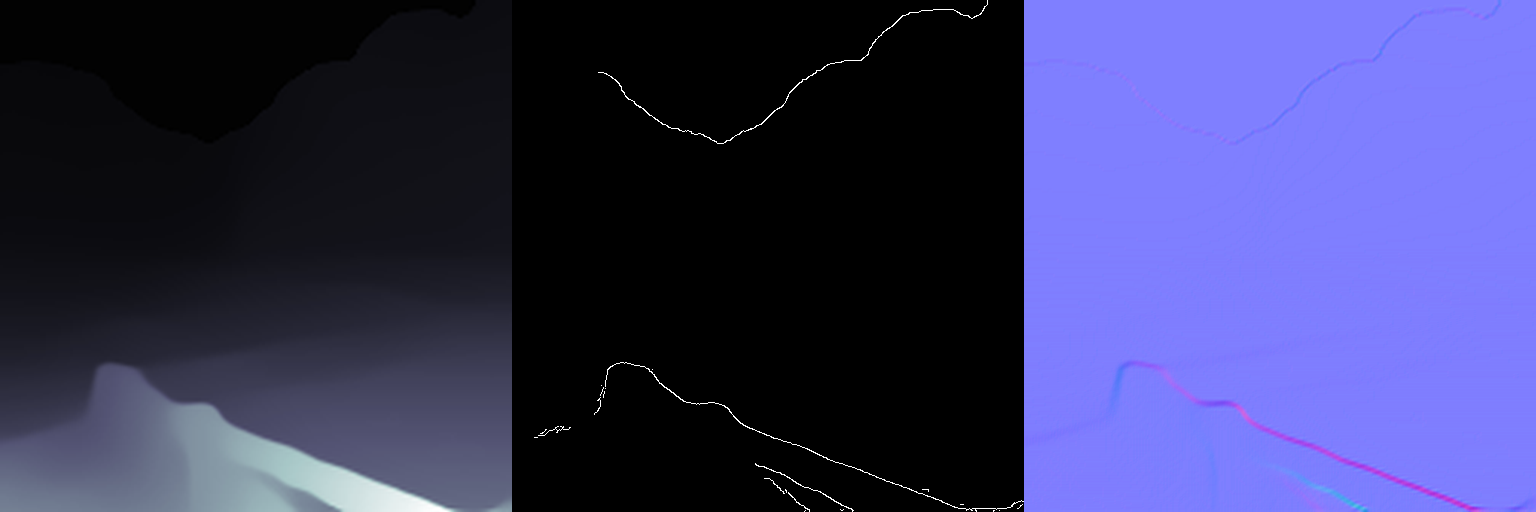

In [42]:
idx = 0
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.08it/s]


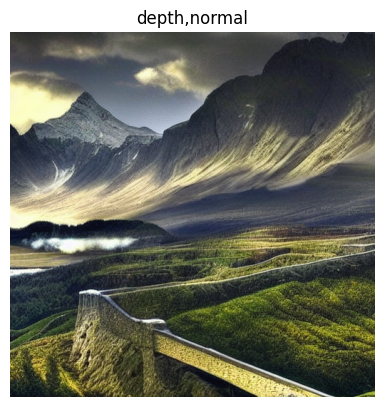

In [45]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

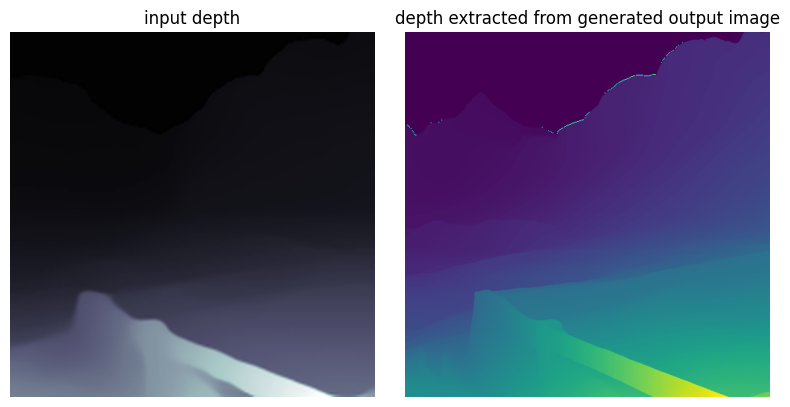

In [50]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## luxury bedroom interior

depth image shape:  (512, 512, 3)
luxury bedroom interior
depth image shape:  (512, 512, 3)


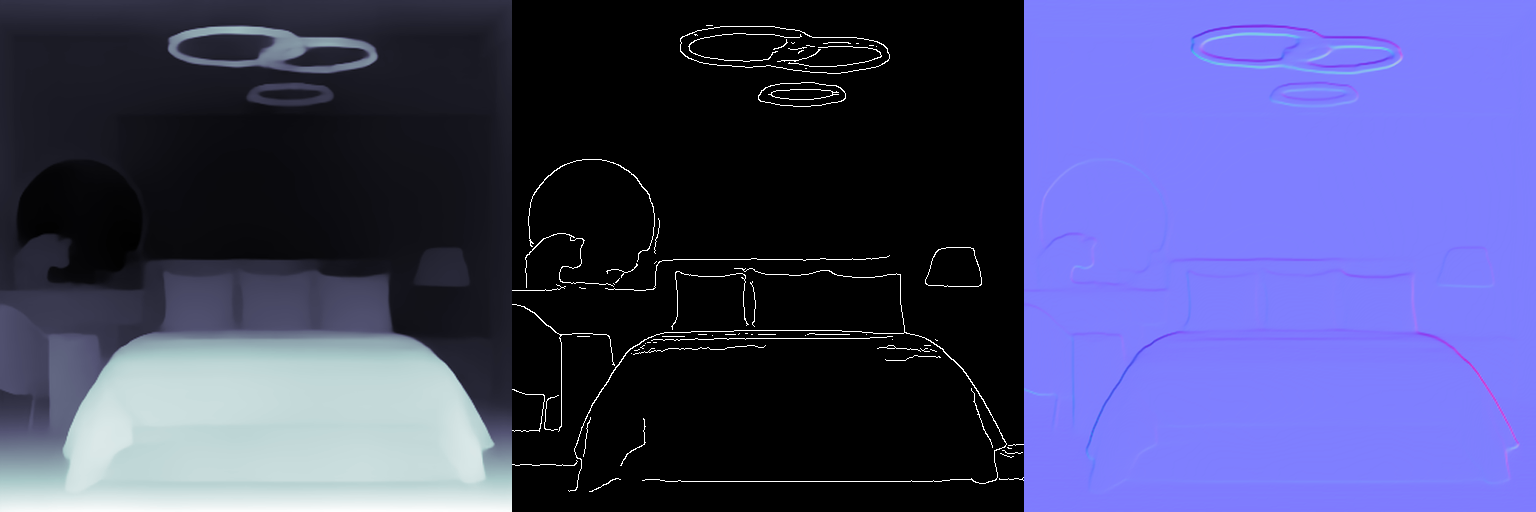

In [51]:
idx = 1
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.78it/s]


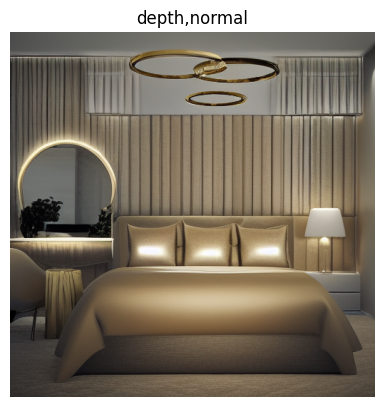

In [53]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

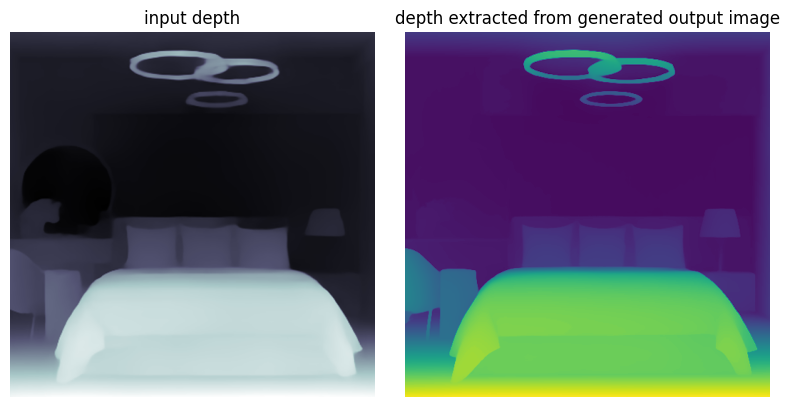

In [54]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## Beautiful snowy mountains

depth image shape:  (512, 512, 3)
Beautiful snowy mountains
depth image shape:  (512, 512, 3)


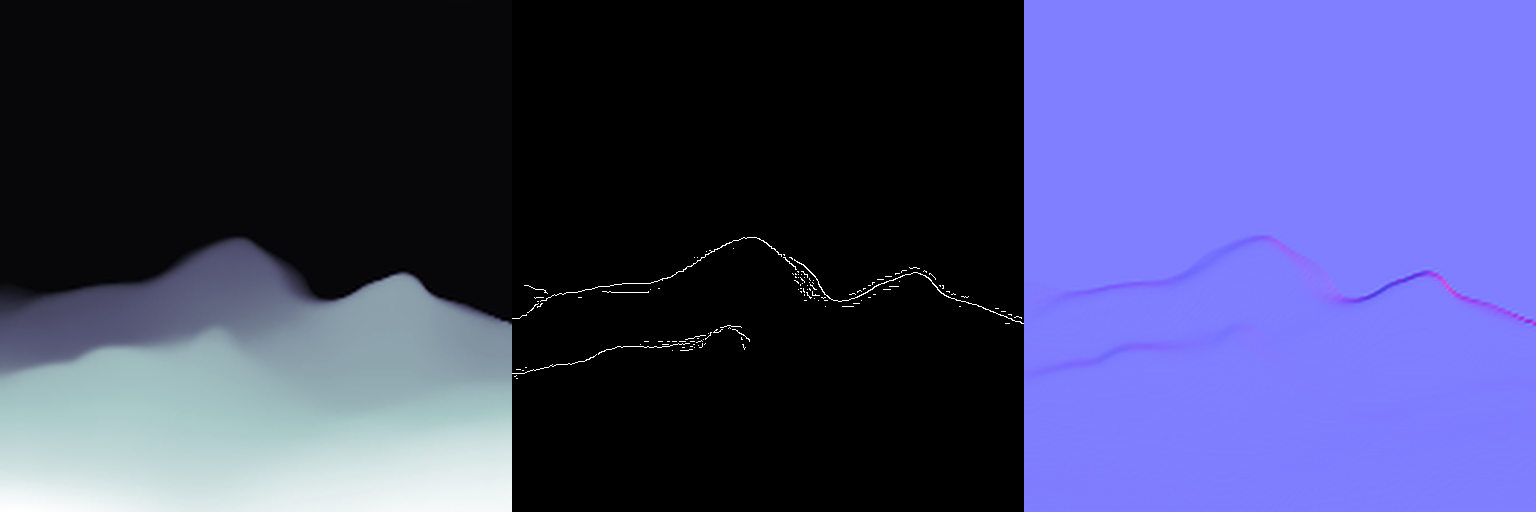

In [57]:
idx = 2
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.60it/s]


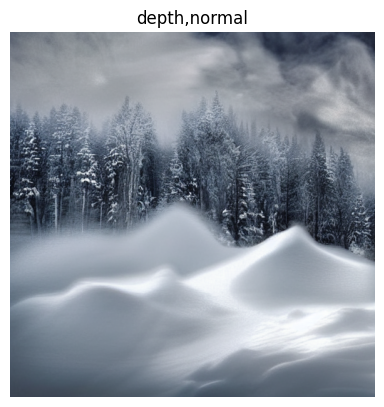

In [62]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

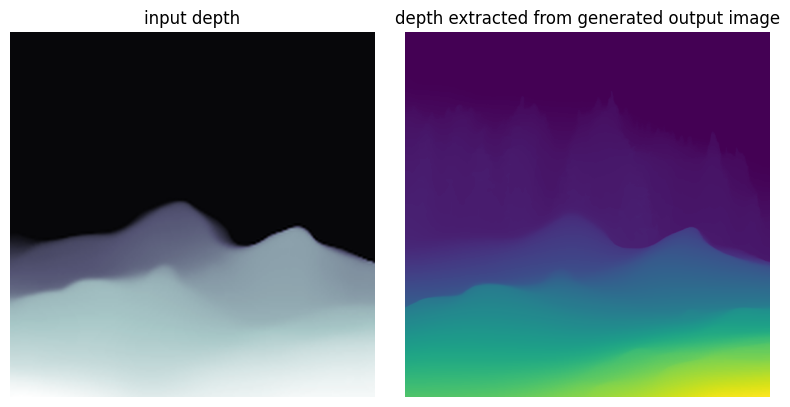

In [63]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## luxurious bedroom interior

depth image shape:  (512, 512, 3)
luxurious bedroom interior
depth image shape:  (512, 512, 3)


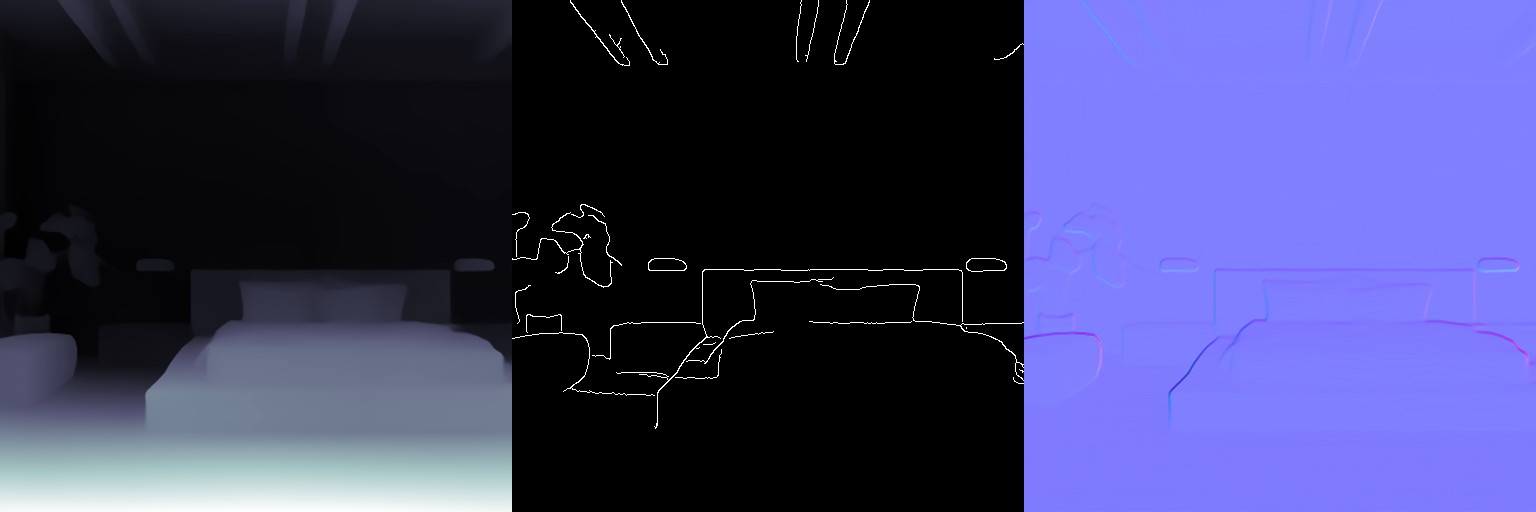

In [64]:
idx = 3
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.40it/s]


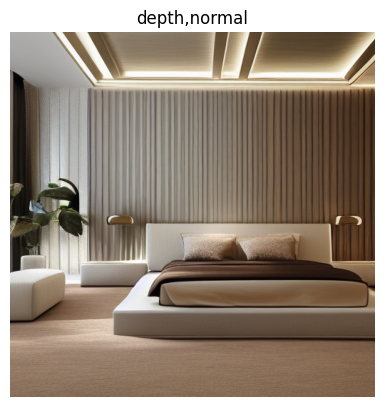

In [66]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

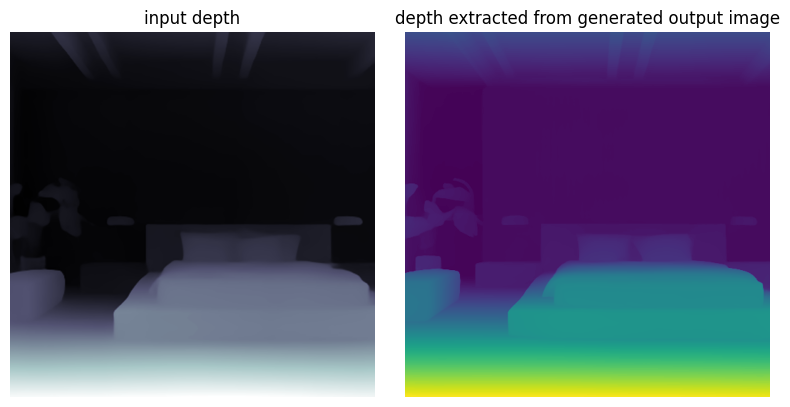

In [67]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## walls with cupboard

depth image shape:  (512, 512, 3)
walls with cupboard
depth image shape:  (512, 512, 3)


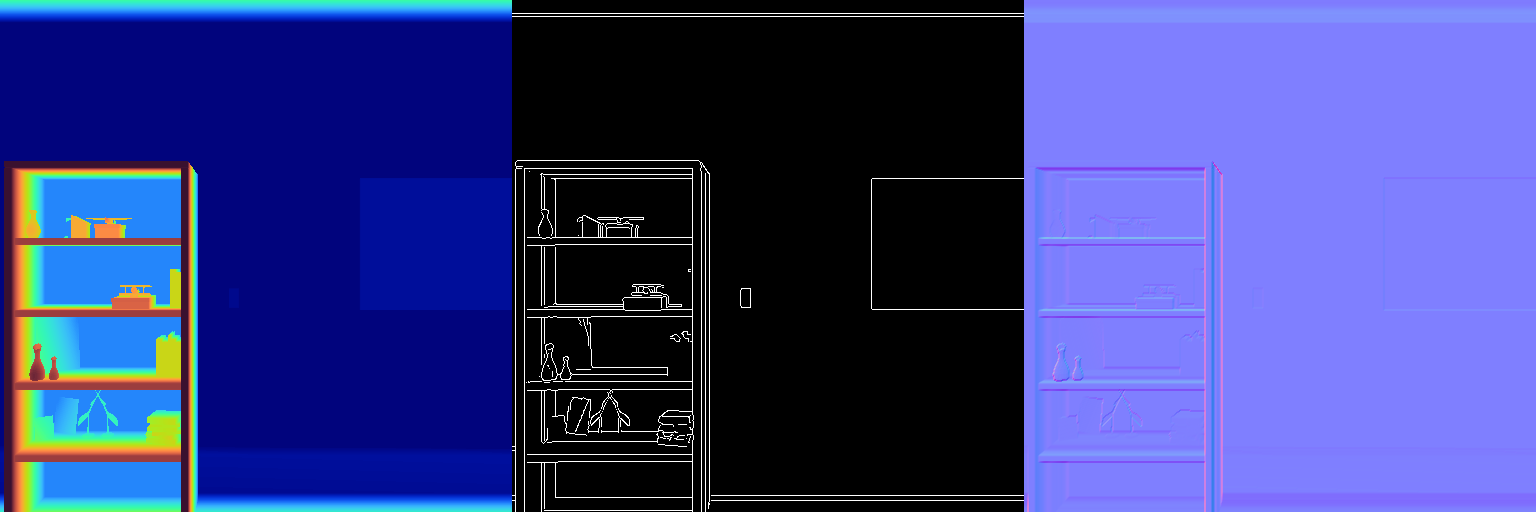

In [73]:
idx = 4
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.25it/s]


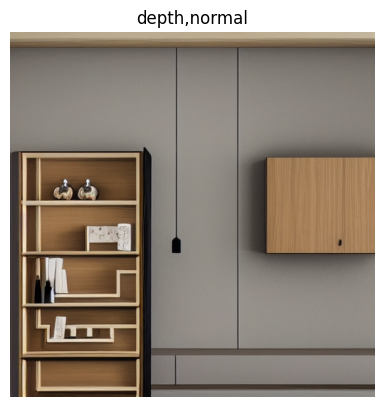

In [74]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

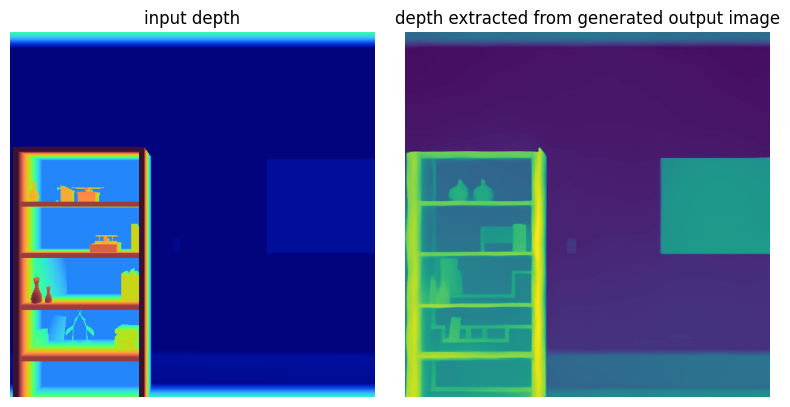

In [75]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## room with chair

depth image shape:  (512, 512)
room with chair
depth image shape:  (512, 512)


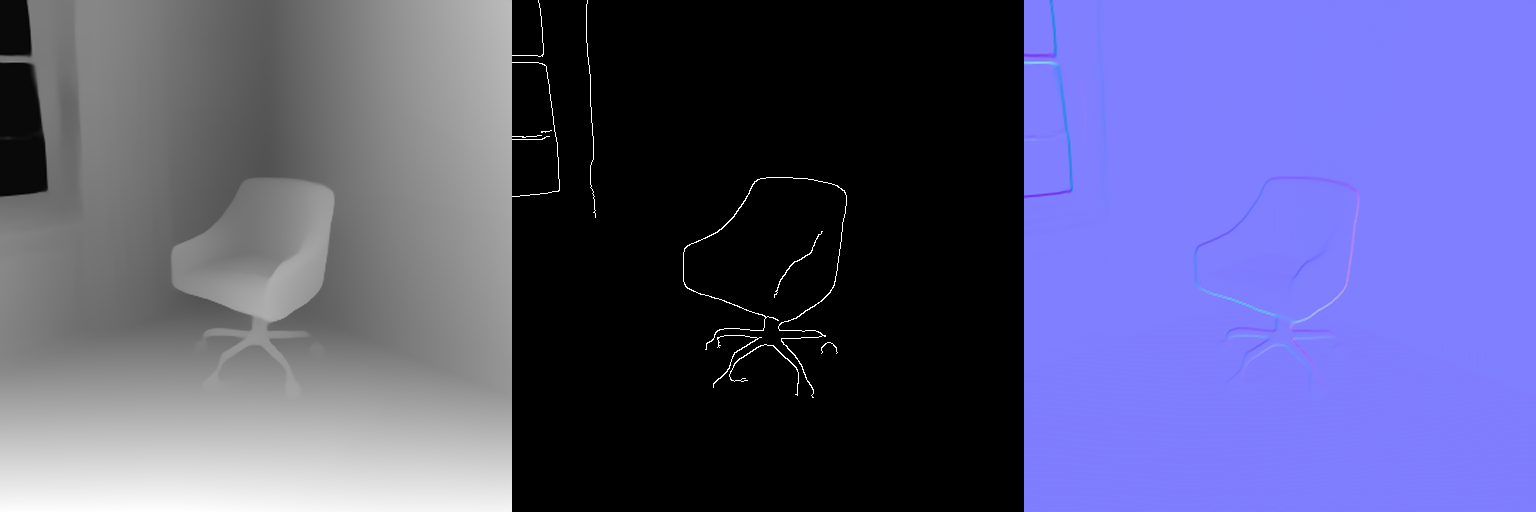

In [76]:
idx = 5
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.57it/s]


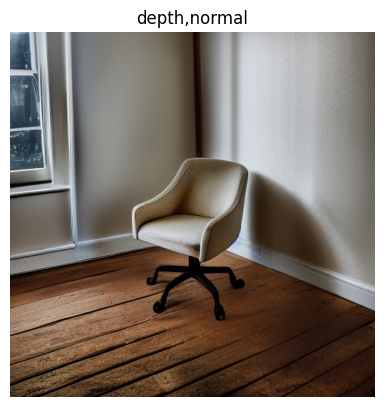

In [79]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

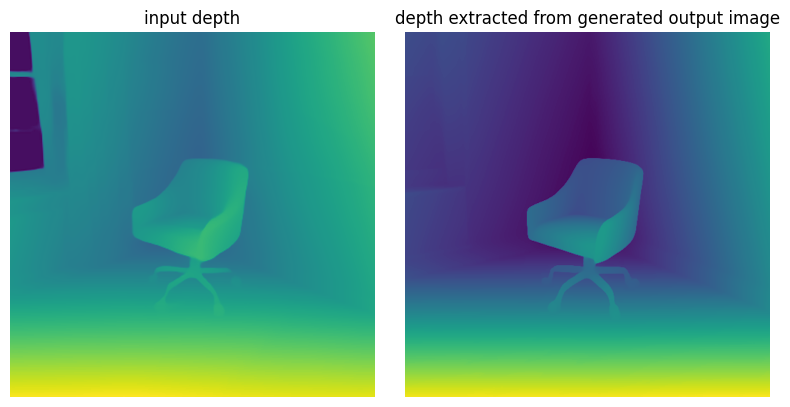

In [80]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])

## House in the forest

depth image shape:  (512, 512)
House in the forest
depth image shape:  (512, 512)


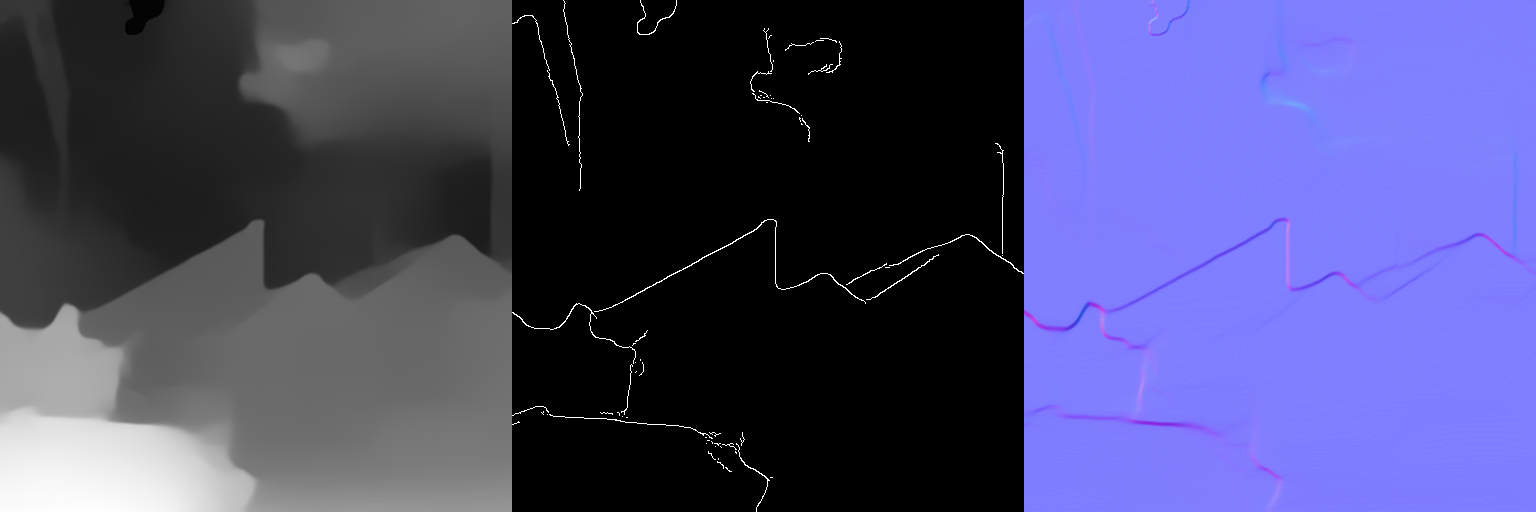

In [84]:
idx = 6
text_prompt = text_prompts[idx]
image_map = get_image_map(idx,size)
print(text_prompt)
conditioning_images = list(get_image_map(idx,size).values())
make_image_grid(conditioning_images, rows=1, cols=len(conditioning_images))

depth image shape:  (512, 512)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.24it/s]


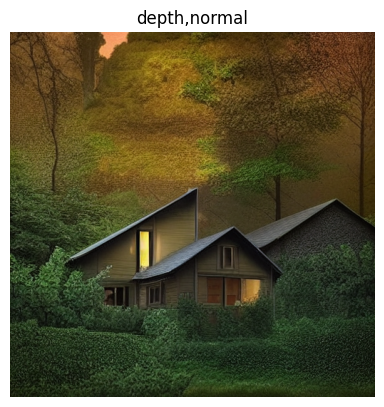

In [85]:
all_outputs = []
titles = []
i = 2
images = get_image_sequence(idx, parameters[i],size)
output = pipelines[i](
    text_prompt, image=images, generator=generator
).images[0]
all_outputs.append(output)
titles.append(get_title(parameters[i]))
display_images_with_titles(all_outputs, titles)

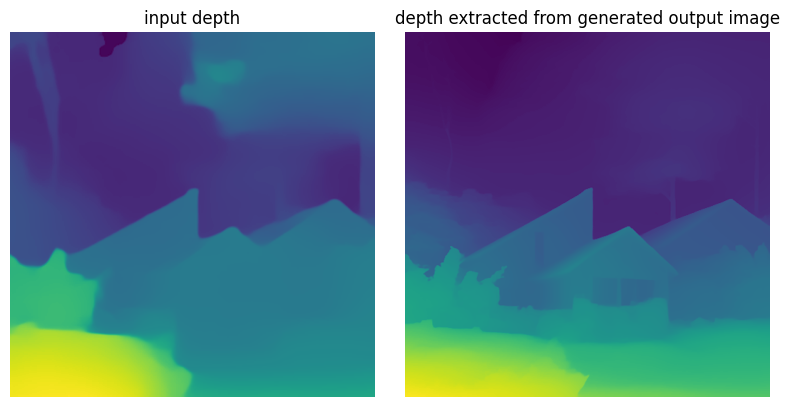

In [86]:
predictions = depth_from_generated_image(output)
display_images_with_titles([images[0], predictions['depth']], ["input depth", "depth extracted from generated output image"])